In [1]:
import torch
import cv2
import numpy as np

from PIL import Image
from torchvision import transforms


In [2]:
import sys
sys.path.append('../')
sys.path.append('../Hand_Pose_Estimation_2D')
print(sys.path)


from Hand_Pose_Estimation_2D.Utils.model import ShallowUNet
from Hand_Pose_Estimation_2D.Utils.utils import (
    COLORMAP,
    heatmaps_to_coordinates,
    N_KEYPOINTS,
    RAW_IMG_SIZE,
    MODEL_IMG_SIZE,
    show_batch_predictions,
    DATASET_MEANS,
    DATASET_STDS,
)

['c:\\Users\\junha\\OneDrive\\Documents\\SUTD\\Term 7\\50.035 - Computer Vision\\Project\\Hand_Detection_YOLOv5', 'C:\\Users\\junha\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'C:\\Users\\junha\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'C:\\Users\\junha\\AppData\\Local\\Programs\\Python\\Python39\\lib', 'C:\\Users\\junha\\AppData\\Local\\Programs\\Python\\Python39', '', 'C:\\Users\\junha\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\junha\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages', 'C:\\Users\\junha\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32', 'C:\\Users\\junha\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32\\lib', 'C:\\Users\\junha\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\Pythonwin', 'C:\\Users\\junha\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\junha\\.ipython', '../', '../Hand_Pose_Estimati

## Loading Trained Model

In [3]:
BEST_WEIGHT_PATH = '.\\yolov5\\runs\\train\\exp5\\weights\\best.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', BEST_WEIGHT_PATH)

Using cache found in C:\Users\junha/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-4-16 torch 1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [4]:
UNET_PATH = '..\\Hand_Pose_Estimation_2D\\model_final'
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")

unet_model = ShallowUNet(3,21)
unet_model.load_state_dict(
    torch.load(UNET_PATH, map_location=DEVICE)
)
unet_model.to(DEVICE)
unet_model.eval()
print("Model loaded")

Model loaded


## Config Variables

In [5]:
JOINT_LIST = [
    [0, 1, 2, 3, 4],
    [0, 5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16],
    [0, 17, 18, 19, 20],
    [5, 9, 13, 17]
]

## WebCam Testing

In [6]:
def plot_boxes(labels, cord, frame):
        """
        Takes a frame and its results as input, and plots the bounding boxes and label on to the frame.
        :param results: contains labels and coordinates predicted by model on the given frame.
        :param frame: Frame which has been scored.
        :return: Frame with bounding boxes and labels ploted on it.
        """
        n = len(labels)
        if n != 0:
            x_shape, y_shape = frame.shape[1], frame.shape[0]
            for i in range(n):
                row = cord[i]
                if row[4] >= 0.5:
                    x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
                    bgr = (0, 255, 0)
                    cv2.rectangle(frame, (x1, y1), (x2, y2), bgr, 2)
                    cv2.putText(frame, f'Hand: {row[4]}%', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 2)

        return frame

In [7]:
def crop_image(cord, frame):
    # n = len(labels)
    # if n != 0:
    x_shape, y_shape = frame.shape[1], frame.shape[0]
    # for i in range(n):
    row = cord
    if row[4] >= 0.5:
        x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
        frame = frame[y1:y2, x1:x2]
    return frame

In [16]:
def pre_process(image):
    x_shape, y_shape = image.shape[1], image.shape[0]
    image_transform = transforms.Compose(
            [   
                transforms.CenterCrop(max(x_shape,y_shape)),
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

    image = Image.fromarray(image)
    image = image_transform(image)
    # image = image.float()
    # image = image.cuda()
    image = image.unsqueeze(0)
    return image

In [9]:
def scale_coord(x,y):
    if x > y:
        primary = x
    else:
        primary = y
    
    

In [10]:
def draw_hands(result, crop_image, frame):
    x_shape, y_shape = crop_image.shape[1], crop_image.shape[0]
    
    result = result.detach().cpu().numpy()
    pred_keypoints = heatmaps_to_coordinates(result).squeeze(0)

    if x_shape > y_shape:
        keypoint_tuples = [tuple((np.multiply(i, x_shape)-[0, (x_shape-y_shape)//2]).astype(int)) for i in pred_keypoints]
        
        
    else:
        keypoint_tuples = [tuple((np.multiply(i, y_shape)-[(y_shape-x_shape)//2, 0]).astype(int)) for i in pred_keypoints]
        

    # keypoint_tuples = [tuple(np.multiply(i, [x_shape,y_shape]).astype(int)) for i in pred_keypoints]
    
    for i in keypoint_tuples:
        cv2.circle(crop_image, i, 2, (255,0,0), 2)
    
    for segment in JOINT_LIST:
        for i in range(len(segment)-1):
            crop_image = cv2.line(crop_image, keypoint_tuples[segment[i]], keypoint_tuples[segment[i+1]], (0,128,0), 1, cv2.LINE_AA)
    return crop_image

In [18]:
Object_colors = list(np.random.rand(80,3)*255)
Object_classes = ['Hand']

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    # Change colour format from BGR to RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Flip image along y axis
    image = cv2.flip(image, 1)

    # Set flag to false
    image.flags.writeable = False

    objs = model(image)

    # print(objs.xyxy)

    labels, cord_thres = objs.xyxyn[0][:, -1].cpu().numpy(), objs.xyxyn[0][:, :-1].cpu().numpy()

    image = plot_boxes(labels, cord_thres, image)

    # image_tensor = pre_process(image)
    # results = unet_model(image_tensor)
    # image = draw_hands(results, image, frame)

    for i in range(len(labels)):
        image_cropped = crop_image(cord_thres[i], image)

        image_tensor = pre_process(image_cropped)
        print(image_tensor)
        results = unet_model(image_tensor)
        image = draw_hands(results, image_cropped, frame)
        
    # # Set flag back to true
    # image.flags.writeable = True

    # Change colour format from RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # print(f'label: {labels}')
    # print(f'cord_thresh: {cord_thres}')

    # for obj in objs: 
    #     # print(obj) 
    #     label = obj['label'] 
    #     score = obj['score'] 
    #     [(xmin,ymin),(xmax,ymax)] = obj['bbox'] 
    #     color = Object_colors[Object_classes.index(label)] 
    #     image = cv2.rectangle(image, (xmin,ymin), (xmax,ymax), color, 2) 
    #     image = cv2.putText(image, f'{label} ({str(score)})', (xmin,ymin),cv2.FONT_HERSHEY_SIMPLEX , 0.75, color, 1, cv2.LINE_AA) 

    cv2.imshow('Hand Tracking', image)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()  



tensor([[[[-2.00916, -2.00916, -2.00916,  ..., -2.00916, -2.00916, -2.00916],
          [-2.00916, -2.00916, -2.00916,  ..., -2.00916, -2.00916, -2.00916],
          [-2.00916, -2.00916, -2.00916,  ..., -2.00916, -2.00916, -2.00916],
          ...,
          [-2.00916, -2.00916, -2.00916,  ..., -2.00916, -2.00916, -2.00916],
          [-2.00916, -2.00916, -2.00916,  ..., -2.00916, -2.00916, -2.00916],
          [-2.00916, -2.00916, -2.00916,  ..., -2.00916, -2.00916, -2.00916]],

         [[-2.49308, -2.49308, -2.49308,  ..., -2.49308, -2.49308, -2.49308],
          [-2.49308, -2.49308, -2.49308,  ..., -2.49308, -2.49308, -2.49308],
          [-2.49308, -2.49308, -2.49308,  ..., -2.49308, -2.49308, -2.49308],
          ...,
          [-2.49308, -2.49308, -2.49308,  ..., -2.49308, -2.49308, -2.49308],
          [-2.49308, -2.49308, -2.49308,  ..., -2.49308, -2.49308, -2.49308],
          [-2.49308, -2.49308, -2.49308,  ..., -2.49308, -2.49308, -2.49308]],

         [[-1.60893, -1.60893,

In [12]:
cap.release()
cv2.destroyAllWindows()

## TESTING

In [13]:
cap = cv2.VideoCapture(0)

ret, frame = cap.read()

print(frame.shape, type(frame))

test_image = Image.fromarray(frame)

print(test_image)

KeyboardInterrupt: 

In [ ]:
test_image_path = 'C:\\Users\\junha\\OneDrive\\Documents\\SUTD\\Term 7\\50.035 - Computer Vision\\Project\\Hand_Pose_Estimation_2D\\FreiHAND_pub_v2\\training\\rgb_plain\\00000001.jpg'

image_raw = Image.open(test_image_path)

print(image_raw)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1B7A29A7220>


In [ ]:
image_transform = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

In [ ]:
image_transform_test = transforms.Compose(
            [   
                transforms.CenterCrop(640),
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

In [ ]:
test_image_transformed = image_transform_test(test_image)
image_raw_transformed = image_transform(image_raw)

print(test_image_transformed.shape)
print(image_raw_transformed.shape, type(image_raw_transformed))

torch.Size([3, 128, 128])
torch.Size([3, 128, 128]) <class 'torch.Tensor'>


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

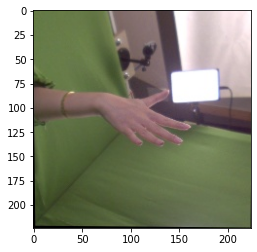

In [ ]:
# image_raw_2 = np.moveaxis(image_raw, 1, -1)
plt.imshow(image_raw)

torch.Size([1, 3, 128, 128])
[[    0.36496     0.45533]
 [    0.42803     0.46458]
 [    0.49983     0.43781]
 [    0.55825     0.41825]
 [    0.61586      0.3935]
 [    0.54224     0.48339]
 [    0.60606     0.50753]
 [    0.65514     0.51103]
 [    0.70209     0.53251]
 [    0.53256      0.5174]
 [    0.59294      0.5481]
 [    0.62347     0.56987]
 [    0.66933     0.58804]
 [    0.48598      0.5322]
 [    0.54254     0.56249]
 [    0.56244     0.58628]
 [    0.59412     0.59804]
 [    0.44064     0.54273]
 [    0.45516      0.5711]
 [    0.47113     0.59662]
 [    0.50119     0.59682]] <class 'numpy.ndarray'>


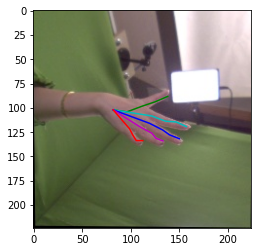

In [ ]:
pred_heatmaps = unet_model(torch.unsqueeze(image_raw_transformed,0))
pred_heatmaps = pred_heatmaps.detach().numpy()
pred_keypoints = np.squeeze(heatmaps_to_coordinates(pred_heatmaps),0)
pred_keypoints_img = pred_keypoints * RAW_IMG_SIZE
print(pred_keypoints, type(pred_keypoints))
# print(pred_keypoints_img)

plt.imshow(image_raw)
for finger, params in COLORMAP.items():
    plt.plot(
        pred_keypoints_img[params["ids"], 0],
        pred_keypoints_img[params["ids"], 1],
        params["color"],
    )

plt.show()

In [ ]:
image_raw_copy = np.array(image_raw)
image_raw_copy = cv2.cvtColor(image_raw_copy, cv2.COLOR_BGR2RGB)
cv2.imshow('test', image_raw_copy)
cv2.waitKey(10000)
cv2.destroyAllWindows()

In [ ]:
keypoint_tuples = [tuple(np.multiply(i, [224,224]).astype(int)) for i in pred_keypoints]

for i in keypoint_tuples:
    cv2.circle(image_raw_copy, i, 2, (0,255,0), 2)

for segment in JOINT_LIST:
    for i in range(len(segment)-1):
        crop_image = cv2.line(image_raw_copy, keypoint_tuples[segment[i]], keypoint_tuples[segment[i+1]], (0,128,0), 1, cv2.LINE_AA)

cv2.imshow('test', image_raw_copy)
cv2.waitKey(10000)
cv2.destroyAllWindows()

torch.Size([1, 3, 128, 128])
[[    0.55224     0.54868]
 [    0.58194     0.54312]
 [    0.58796     0.54685]
 [    0.59089     0.55694]
 [    0.56329     0.54803]
 [    0.56108     0.53219]
 [    0.54104      0.5039]
 [    0.57063     0.52424]
 [    0.50854     0.51415]
 [    0.55157     0.50293]
 [    0.51337     0.51447]
 [    0.52749     0.51342]
 [    0.52854     0.51084]
 [    0.56757     0.53793]
 [    0.54086     0.53077]
 [    0.55156     0.52563]
 [    0.56244     0.51269]
 [    0.57392     0.55322]
 [    0.56964     0.55443]
 [    0.59247     0.54819]
 [    0.59736     0.53524]] <class 'numpy.ndarray'>


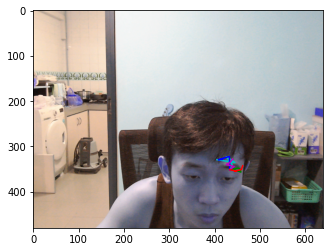

In [ ]:
pred_heatmaps = unet_model(torch.unsqueeze(test_image_transformed,0))
pred_heatmaps = pred_heatmaps.detach().numpy()
pred_keypoints = np.squeeze(heatmaps_to_coordinates(pred_heatmaps),0)
pred_keypoints_img = pred_keypoints * 640 + [80,0]
print(pred_keypoints, type(pred_keypoints))
# print(pred_keypoints_img)

plt.imshow(test_image)
for finger, params in COLORMAP.items():
    plt.plot(
        pred_keypoints_img[params["ids"], 0],
        pred_keypoints_img[params["ids"], 1],
        params["color"],
    )

plt.show()

torch.Size([1, 3, 128, 128])
[[    0.55224     0.54868]
 [    0.58194     0.54312]
 [    0.58796     0.54685]
 [    0.59089     0.55694]
 [    0.56329     0.54803]
 [    0.56108     0.53219]
 [    0.54104      0.5039]
 [    0.57063     0.52424]
 [    0.50854     0.51415]
 [    0.55157     0.50293]
 [    0.51337     0.51447]
 [    0.52749     0.51342]
 [    0.52854     0.51084]
 [    0.56757     0.53793]
 [    0.54086     0.53077]
 [    0.55156     0.52563]
 [    0.56244     0.51269]
 [    0.57392     0.55322]
 [    0.56964     0.55443]
 [    0.59247     0.54819]
 [    0.59736     0.53524]] <class 'numpy.ndarray'>


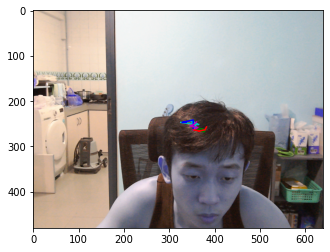

In [ ]:
pred_heatmaps = unet_model(torch.unsqueeze(test_image_transformed,0))
pred_heatmaps = pred_heatmaps.detach().numpy()
pred_keypoints = np.squeeze(heatmaps_to_coordinates(pred_heatmaps),0)
pred_keypoints_img = pred_keypoints * [640,480]
print(pred_keypoints, type(pred_keypoints))
# print(pred_keypoints_img)

plt.imshow(test_image)
for finger, params in COLORMAP.items():
    plt.plot(
        pred_keypoints_img[params["ids"], 0],
        pred_keypoints_img[params["ids"], 1],
        params["color"],
    )

plt.show()

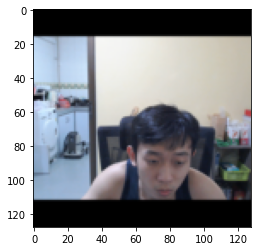

In [ ]:
plt.imshow(np.array(test_image)[:,:,::-1])

test_image_2 = transforms.CenterCrop(640)(test_image)
test_image_2 = transforms.Resize(128)(test_image_2)

plt.imshow(np.array(test_image_2)[:,:,::-1])